## Cross-validation of Single- and Multi-task Gaussian process

In this notebook we will use the 2D retention model, and the online and offline system that we set up in the [previous notebook](sampling_retention_parameters.ipynb) in order to empirically test our single-task and multi-task  Gaussian process models.

In a nutshell:
- We generate 20 online method parameters and 400 offline method parameters and compute their respective objective function values.
- The single-task model is fit only to the online data.
- The multi-task model is fit to both the online and offline data.
- In the leave-one-out cross validation, we remove one online observation and fit the models to the remaining 19 points (plus 100 offline method parameters for the multi-task model.
- It is shown that by incorporating the offline data, the multi-task model is much better at making correct predictions.

The results and details of this notebook are described in Section XX of the main paper.

We start out with importing the required packages and defining the run device (GPU or CPU, defaulting to GPU if there is CUDA support).

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from botorch import fit_gpytorch_model

from botorch.models import SingleTaskGP
from botorch.models.multitask import MultiTaskGP
from gpytorch import ExactMarginalLogLikelihood

from tqdm import tqdm

tkwargs = (
    {  # Dictionary containing information about data type and data device
        "dtype": torch.double,
        "device": torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
    }
)
# Writing the dictionary to a DataFrame
df = pd.DataFrame([tkwargs])
# Saving the DataFrame to a CSV file, this will be read by other functions.
df.to_csv('data/tkwargs.csv', index=False)

from bo_code.MTBO import generate_initial_data_mtgp, add_task_feature
from botorch.cross_validation import gen_loo_cv_folds
from botorch.models.transforms import Standardize, Normalize
from rm_code.retention_model import online_system, offline_system
from utils.utils import bo_to_rm_2D, check_pars

## Setting up the retention model

In this cell we will set up all values related to the 2DLC sytem, such as dead time, dwell time, plate number, modulation time, etc.
In addition, we set 1D and 2D parameters for a simple linear gradient in the first dimension, and a second dimension gradient program without a gradient shift, for later use. Lastly we set maximum times in the first and second dimension (max_T), which will be thresholds for the evaluation of objective functions later.

Also, we load the retention parameters we generated in the [previous notebook](sampling_retention_parameters.ipynb).

In [6]:
### Set up a 1D retention model

# Set some default parameters for first dimension
t_0_1D = 4.5 # dead time
t_D_1D = 0.1 # dwell time
N_1D = 400 # plate number 1D
t_init_1D = 2 # init time

# create dictionary for the above described parameters
settings_1D = {'t_0': t_0_1D, 't_D': t_D_1D, 'N': N_1D, 't_init': t_init_1D}

# Try out a 1D gradient
phi_list_1D = [0, 0.25, 0.5, 1] # phi values
t_list_1D = [0, 25, 50, 100] # time values

### Set up a 2D retention model

### Define 2D parameters
N_2D = 5000 # plate number 2D

t_M_2D = 2 #/ 3 # modulation time minutes
t_G_2D = 1.8 #/ 3 # gradient time minutes
t_init_2D = 0.1 #/ 3 # init time minutes
t_D_2D = 0.01 # dwell time in minutes
t_0_2D = 0.01 # dead time in minutes

# create dictionary for the above described parameters
settings_2D = {'t_M': t_M_2D, 't_G': t_G_2D, 't_init': t_init_2D, 't_D': t_D_2D, 't_0': t_0_2D, 'N': N_2D}

# Try out a shifting gradient
phi_init_2D = [0.0, 0.0, 0.0, 0.0, 0.0]
phi_final_2D = [1, 1, 1, 1, 1]
t_list_2D = [0, t_0_1D, 40, 45, t_list_1D[-1]]

# something more optimal
# Try out a 1D gradient
phi_list_1D_opt = [0.1, 0.3, 1, 1] # phi values
t_list_1D_opt = [0, 25, 80, 100] # time values

phi_init_2D_opt = [0.1, 0.1, 0.1, 0.3, 0.4]
phi_final_2D_opt = [0.20, 0.20, 0.2, 0.7, 1]
t_list_2D_opt = [0, t_0_1D, 45, 50, t_list_1D[-1]]

max_T = [100, t_M_2D]

# check if the parameters are valid
check_pars(settings_2D, t_list_1D, phi_init_2D, phi_final_2D, t_list_2D)

# Load the retention parameters created in "sampling_retention_paremters.ipynb"
ret_pars = pd.read_csv('data/retention_system.csv').to_dict(orient='list')
n_analytes = len(ret_pars['k0_1D'])

## Defining fixed- and optimizable parameters, bounds and inequality constraints


In [7]:
# Set some fixed parameters
#n_analytes=80 # number of analytes

t_max = 100 # maximum time

phi_min, phi_max = 0, 1 # maximum phi
fixed_phi_pars_1D = torch.tensor([[phi_min], [phi_max]]) # fixed phi points
fixed_time_pars_1D = torch.tensor([[0.], [t_max]]) # at fixed time points

fixed_phi_pars_2D = torch.tensor([[phi_min], [phi_max]]) # fixed phi points
fixed_time_pars_2D = torch.tensor([[0.],[t_0_1D], [t_max]]) # at fixed time points

# Pars vector will look like this: [phi1, phi2, t1, t2, phi_i1, phi_i2, phi_i3, phi_f1, phi_f2, phi_f3, t1_shift, t2_shift]
bounds = torch.stack([
    torch.tensor([phi_min, phi_min, 0.1, 0.1, phi_min, phi_min, phi_min, phi_min, phi_min, phi_min, t_0_1D, t_0_1D]),
    torch.tensor([phi_max, phi_max, t_max-0.1, t_max-0.1, phi_max, phi_max, phi_max, phi_max, phi_max, phi_max, t_max-t_M_2D, t_max-t_M_2D])]
)

# bounds after normalization to [0,1]
norm_bounds = torch.stack([torch.zeros(12), torch.ones(12)])

inequality_constraints= [(torch.tensor([0,1]), torch.tensor([-1., 1.]), 0.0), (torch.tensor([2,3]), torch.tensor([-1., 1.]), 0.1), (torch.tensor([10,11]), torch.tensor([-1., 1.]), t_M_2D), (torch.tensor([4,8]), torch.tensor([-1., 1.]), 0.0), (torch.tensor([5,9]), torch.tensor([-1., 1.]), 0.0)]

# missing analytes and noise for offline system.
# draw 10 random indices between 0 and n_analytes
remove_indices = np.random.randint(0, n_analytes, 10)
# create dictionary with noise levels
noise = {'tR_1D': 0.3, 'tR_2D': 0.05, 'W_1D': 0.2, 'W_2D': 0.01}

## Creating a dataset

We will now sample method parameters for the online and offline system and will evaluate these method parameters on the online and offline system respectively, to generate a dataset on which to perform leave-one-out cross validation using our GP models.

In [8]:
# what we want to do here is to create a bunch of training data, both online and offline.
# then fit these models using multi-task and single-task GPs, and plot correlation plots.

# generate initial samples
n_init_online = 24
n_init_offline = 120

pars_online_init, pars_offline_init = generate_initial_data_mtgp(n_init_online, n_init_offline, bounds, inequality_constraints)

# create lists to fill with results per trial
scores_single_task = []
scores_online_mt = []
scores_offline_mt = []

pars_single_task = []
pars_online_mt = []
pars_offline_mt = []

# Perform initial online experiments
phi_list_1D, t_list_1D, phi_init_2D, phi_final_2D, t_list_2D = bo_to_rm_2D(pars_online_init, fixed_phi_pars_1D, fixed_time_pars_1D, fixed_phi_pars_2D, fixed_time_pars_2D)

for i in tqdm(range(len(pars_online_init))):
    tR_list_1D, W_list_1D, tR_list_2D, W_list_2D, res_score, time_score = online_system(ret_pars, settings_1D, settings_2D, phi_list_1D[i], t_list_1D[i],phi_init_2D[i], phi_final_2D[i], t_list_2D[i], max_T)

    # now we need to add the pars and scores to online_mt and single_task as they will both share the same initial experiments
    scores_online_mt.append(res_score - 0.1*time_score)
    pars_online_mt.append(pars_online_init[i])

    scores_single_task.append(res_score - 0.1*time_score)
    pars_single_task.append(pars_online_init[i])

# Perform initial offline experiments
phi_list_1D, t_list_1D, phi_init_2D, phi_final_2D, t_list_2D = bo_to_rm_2D(pars_offline_init, fixed_phi_pars_1D, fixed_time_pars_1D, fixed_phi_pars_2D, fixed_time_pars_2D)

for i in tqdm(range(len(pars_offline_init))):

    tR_list_1D, W_list_1D, tR_list_2D, W_list_2D, res_score, time_score = offline_system(ret_pars, settings_1D, settings_2D, phi_list_1D[i], t_list_1D[i],phi_init_2D[i], phi_final_2D[i], t_list_2D[i], max_T, noise, remove_indices)

    # now we need to add the pars and scores to offline_mt
    scores_offline_mt.append(res_score - 0.1*time_score)
    pars_offline_mt.append(pars_offline_init[i])


100%|██████████| 120/120 [00:18<00:00,  6.39it/s]


## Leave-one-out cross validation on the Multi-Task Gaussian process model

We will now perform leave-one-out cross validation for the Multi-Task GP. This is done by generating cross folds of 19 online training points and 1 online test points, for 20 folds. The model will have access to all 400 offline trainng points.

The model is then fit on the training points, and the fitted model is used to predict the test point. This is then repeated for all folds.

In [9]:
cv_results_mt = pd.DataFrame()
# create leave-one-out cross folds
cv_folds = gen_loo_cv_folds(pars_online_init.to(**tkwargs), torch.tensor(scores_online_mt).unsqueeze(-1).to(**tkwargs))

for i in tqdm(range(len(cv_folds.train_X))):
    # need to add the task feature to the training data using add_task_feature
    tr_X = add_task_feature(cv_folds.train_X[i].to(**tkwargs), 0)
    # add task feature to the offline data
    tr_X_offline = add_task_feature(torch.tensor(pars_offline_init).to(**tkwargs), 1)
    # need to add the offline data to the training data
    tr_X = torch.cat((tr_X, tr_X_offline), 0).to(**tkwargs)
    tr_Y = torch.cat((cv_folds.train_Y[i], torch.tensor(scores_offline_mt).unsqueeze(-1).to(**tkwargs)), 0)

    te_X = cv_folds.test_X[i]
    # add_task_feature
    te_X = add_task_feature(te_X, 0)

    te_Y = cv_folds.test_Y[i]

    model = MultiTaskGP(tr_X, tr_Y, task_feature=-1, outcome_transform=Standardize(m=1),
                        input_transform=Normalize(d=tr_X.shape[-1], bounds=bounds,
                        indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]))
    model_mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(model_mll)

        # Evaluate model on test data
    with torch.no_grad():
        observed_pred = model.posterior(te_X[:, :-1], te_X[:, -1])

    # write results from posterior to cv_results dataframe
    cv_results_mt = pd.concat([cv_results_mt, pd.DataFrame({'mean': observed_pred.mean[0].cpu(), 'lower': observed_pred.mvn.confidence_region()[0].cpu(),
                                                            'upper': observed_pred.mvn.confidence_region()[1].cpu(), 'true': te_Y[0].cpu(), 'task': te_X[:, -1].cpu()})])


100%|██████████| 24/24 [00:29<00:00,  1.22s/it]


In [10]:
# print(model.task_covar_module.covar_factor)
# cf = model.task_covar_module.covar_factor.detach().cpu()
# var = model.task_covar_module.var.detach().cpu()
# print(model.task_covar_module.covar_matrix())
# print(model.covar_module.outputscale)
#cf @ cf.transpose(-1, -2) + torch.diag_embed(var)

## Leave-one-out cross validation on the Multi-Task Gaussian process model

Likewise, we perform leave-one-out cross validation for the single task model, which is only trained on the online data.

In [11]:
cv_results_gp1 = pd.DataFrame()

for i in tqdm(range(len(cv_folds.train_X))):
    tr_X = cv_folds.train_X[i]
    tr_Y = cv_folds.train_Y[i]
    te_X = cv_folds.test_X[i]
    te_Y = cv_folds.test_Y[i]

    # Fit model on training data
    model = SingleTaskGP(tr_X, tr_Y, input_transform=Normalize(d=len(bounds[0]), bounds=bounds), outcome_transform=Standardize(m=1))
    model_mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(model_mll)

    # Evaluate model on test data
    with torch.no_grad():
        observed_pred = model.posterior(te_X)

    # # write results from posterior to cv_results dataframe
    cv_results_gp1 = pd.concat([cv_results_gp1, pd.DataFrame({'mean': observed_pred.mean[0].cpu(), 'lower': observed_pred.mvn.confidence_region()[0].cpu(),
                                                            'upper': observed_pred.mvn.confidence_region()[1].cpu(), 'true': te_Y[0].cpu()})])

100%|██████████| 24/24 [00:06<00:00,  3.50it/s]


## Visualize results

We now visualize the results of the leave-one-out cross validation. It can be observed that the single-task GP fit only to the online data is struggling to make reliable predictions, due to the relatively high dimensionality and limited data. The multi-task model, fit to both the online and (biased) offline data allows for more accurate predictions.
Therefore, the multi-task model will likely be a better model in the Bayesian optimization loop that we will use in the [next notebook](2dlc_rm.ipynb).

In [15]:
# plotting functionality
def min_max_cross_val_plot(df):
    # get min and max of all columns for plot bounds
    min_val = min(df['lower']) - 0.2
    max_val = max(df['upper']) + 0.2
    return min_val, max_val

def plot_cross_val(df, title):
    # plot the cross validation results
    fig, ax = plt.subplots()
    min_val, max_val = min_max_cross_val_plot(df)
    min_val, max_val = 0, 75
    ax.set_title(title)
    ax.set_ylim([min_val, max_val])
    ax.set_xlim([min_val, max_val])
    ax.set_xlabel("Observed value")
    ax.set_ylabel("Predicted value")

    ax.errorbar(
        x=df['true'],
        y= df['mean'],
        xerr=0,
        yerr=((df['upper'] - df['lower'])/2),
        fmt='o',
        ecolor='tab:blue',
        mec='white',
    )
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=3)

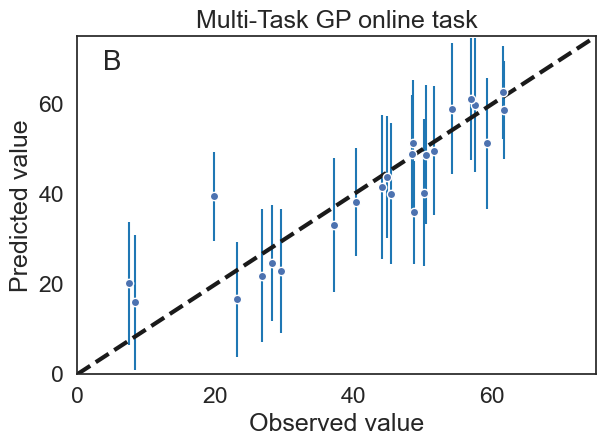

In [16]:
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('white')

plot_cross_val(cv_results_mt[cv_results_mt['task'] == 0], 'Multi-Task GP online task')
# plt.xlim(20, 150)
# plt.ylim(20, 150)
plt.tight_layout()
# annote plot with B
plt.annotate('B', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=20)
# save figure
plt.savefig('figures/cross_val_multi_task_sample_synth.pdf', dpi=500, bbox_inches='tight')
plt.savefig('figures/cross_val_multi_task_sample_synth.png', dpi=500, bbox_inches='tight')
plt.show()

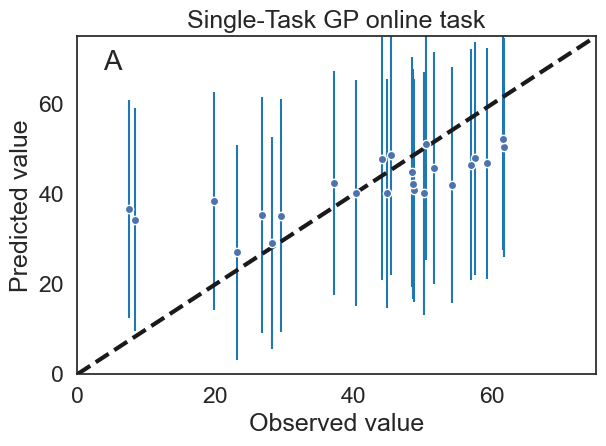

In [17]:
plot_cross_val(cv_results_gp1, 'Single-Task GP online task')
# plt.xlim(20, 150)
# plt.ylim(20, 150)
plt.tight_layout()
# annotate plot with A
plt.annotate('A', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=20)
# save figure
plt.savefig('figures/cross_val_single_task_sample_synth.pdf', dpi=500, bbox_inches='tight')
plt.savefig('figures/cross_val_single_task_sample_synth.png', dpi=500, bbox_inches='tight')
plt.show()